# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Will-a-tropical-storm-make-landfall?" data-toc-modified-id="Will-a-tropical-storm-make-landfall?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Will a tropical storm make landfall?</a></div><div class="lev2 toc-item"><a href="#Generate-the-dataset" data-toc-modified-id="Generate-the-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Generate the dataset</a></div><div class="lev3 toc-item"><a href="#Dataset-description" data-toc-modified-id="Dataset-description-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Dataset description</a></div><div class="lev3 toc-item"><a href="#Open-the-source-dataset" data-toc-modified-id="Open-the-source-dataset-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Open the source dataset</a></div><div class="lev3 toc-item"><a href="#Extract,-transform-and--load-features-(ETL)" data-toc-modified-id="Extract,-transform-and--load-features-(ETL)-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Extract, transform and  load features (ETL)</a></div><div class="lev3 toc-item"><a href="#Generate-random-sampling-of-each-prediction-(class)-value-and-generate-ARFF-file" data-toc-modified-id="Generate-random-sampling-of-each-prediction-(class)-value-and-generate-ARFF-file-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Generate random sampling of each prediction (class) value and generate ARFF file</a></div><div class="lev3 toc-item"><a href="#Save-DataFrame-datasets-(all,-landfall/nolandfall-training-sets-and-test-set)-as-tables-in-HDF5" data-toc-modified-id="Save-DataFrame-datasets-(all,-landfall/nolandfall-training-sets-and-test-set)-as-tables-in-HDF5-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Save DataFrame datasets (all, landfall/nolandfall training sets and test set) as tables in HDF5</a></div><div class="lev3 toc-item"><a href="#Visualize-the-dataset-storms-tracks" data-toc-modified-id="Visualize-the-dataset-storms-tracks-1.1.6"><span class="toc-item-num">1.1.6&nbsp;&nbsp;</span>Visualize the dataset storms tracks</a></div><div class="lev2 toc-item"><a href="#Machine-learning-analysis" data-toc-modified-id="Machine-learning-analysis-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Machine learning analysis</a></div><div class="lev3 toc-item"><a href="#Decision-Tree" data-toc-modified-id="Decision-Tree-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Decision Tree</a></div><div class="lev3 toc-item"><a href="#Naive-Bayes" data-toc-modified-id="Naive-Bayes-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Naive Bayes</a></div><div class="lev3 toc-item"><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Logistic Regression</a></div><div class="lev3 toc-item"><a href="#Nearest-Neighbor" data-toc-modified-id="Nearest-Neighbor-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Nearest Neighbor</a></div><div class="lev3 toc-item"><a href="#Support-Vector-Machines" data-toc-modified-id="Support-Vector-Machines-1.2.5"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>Support Vector Machines</a></div>

* **FA16-BL-INFO-I526-34917**
* **Applied Machine Learning**
* **Gerald Manipon, MS Data Science student - Indiana University**
* **gmanipon@iu.edu**
* **this jupyter notebook can be found here: https://github.com/pymonger/tropicalstorm-ml-analysis**

# Will a tropical storm make landfall?

As a native of the Hawaiian Islands, the recent tropical storms in 2016 (Madeline and Lester) that threatened the state has sparked a very interesting and personal question. Can we predict whether or not a tropical storm will make landfall and possibly affect the safety and lives of the inhabitants? Currently there are real-time storm tracking models that enable our emergency response agencies to be as responsive as possible and to give up-to-the-minute status on potential threats. However, what does historical data say and can we predict landfall using machine learning on the initial observation of a tropical storm?

## Generate the dataset

### Dataset description

The source dataset I will use comes from the IBTrACS (International Best Track Archive for Climate Stewardship) project: https://www.ncdc.noaa.gov/ibtracs/index.php. This project is endorsed by the WMO (World Meteorological Organization) as an "official archiving and distribution resource for tropical cyclone best track data". The IBTrACS project provides datasets that:

* Contains the most complete global set of historical tropical cyclones available
* Combines information from numerous tropical cyclone datasets
* Simplifies inter-agency comparisons by providing storm data from multiple sources in one place
* Provides data in popular formats to facilitate analysis
* Checks the quality of storm inventories, positions, pressures, and wind speeds, passing the information on to the user

I will be using the IBTrACS-WMO NetCDF file that contains all storms: https://www.ncdc.noaa.gov/ibtracs/index.php?name=wmo-data. Since NetCDF is a self-describing format, info about the variables contained in this dataset can be introspected. Additional info about the variables is located here: ftp://eclipse.ncdc.noaa.gov/pub/ibtracs/v03r08/wmo/netcdf/README.netcdf.

I will be performing some ETL (extraction, transformation and loading) tasks to prepare and filter (remove records with missing values) the source dataset to a derived dataset which I will use for this analysis. The source dataset essentially aggregates every recorded tropical storm from different source agencies and provides time-series information of pertinent variables describing the storm as it progressed through its track. *Since I'm only interested in being able to predict whether or not the storm will make landfall based on the storm's genesis and initial observation, my derived dataset will be composed of features that are essentially the values of the source dataset variables at observation **t<sub>0</sub>**.*

The class variable (prediction variable) will be derived from the source dataset's **landfall** variable:

* **landfall** { True, False }
```
    short landfall(storm, time) ;
        landfall:long_name = "Minimum distance to land until next report (0=landfall)" ;
        landfall:units = "km" ;
        landfall:_FillValue = -999s ;
```

I will aggregate this variable into a single value of **True** or **False** if it makes landfall at any time in a storm's track.

The features I will include from the source dataset are:

* **genesis_basin** { 0 = NA - North Atlantic, 1 = SA - South Atlantic, 2 = WP - West Pacific, 3 = EP - East Pacific, 4 = SP - South Pacific, 5 = NI - North Indian, 6 = SI - South Indian }
  ```
    byte genesis_basin(storm) ;
        genesis_basin:long_name = "Basin of genesis" ;
        genesis_basin:units = " " ;
        genesis_basin:key = "0 = NA - North Atlantic\n",
    "1 = SA - South Atlantic\n",
    "2 = WP - West Pacific\n",
    "3 = EP - East Pacific\n",
    "4 = SP - South Pacific\n",
    "5 = NI - North Indian\n",
    "6 = SI - South Indian\n",
    "7 = AS - Arabian Sea\n",
    "8 = BB - Bay of Bengal\n",
    "9 = EA - Eastern Australia\n",
    "10 = WA - Western Australia\n",
    "11 = CP - Central Pacific\n",
    "12 = CS - Carribbean Sea\n",
    "13 = GM - Gulf of Mexico\n",
    "14 = MM - Missing" ;
        genesis_basin:Note = "Based on where the storm began" ;
  ```
  * the additional variable info at ftp://eclipse.ncdc.noaa.gov/pub/ibtracs/v03r08/wmo/netcdf/README.netcdf states that only values 0-6 are used for this variable thus I will be discretizing the values for this feature
* **sub_basin** of first observation { 0 = NA - North Atlantic, 1 = SA - South Atlantic, 2 = WP - West Pacific, 3 = EP - East Pacific, 4 = SP - South Pacific, 5 = NI - North Indian, 6 = SI - South Indian, 7 = AS - Arabian Sea, 8 = BB - Bay of Bengal, 9 = EA - Eastern Australia, 10 = WA - Western Australia, 11 = CP - Central Pacific, 12 = CS - Carribbean Sea, 13 = GM - Gulf of Mexico, 14 = MM - Missing }
  ```
    byte sub_basin(storm, time) ;
        sub_basin:long_name = "Sub-Basin" ;
        sub_basin:units = " " ;
        sub_basin:key = "0 = NA - North Atlantic\n",
    "1 = SA - South Atlantic\n",
    "2 = WP - West Pacific\n",
    "3 = EP - East Pacific\n",
    "4 = SP - South Pacific\n",
    "5 = NI - North Indian\n",
    "6 = SI - South Indian\n",
    "7 = AS - Arabian Sea\n",
    "8 = BB - Bay of Bengal\n",
    "9 = EA - Eastern Australia\n",
    "10 = WA - Western Australia\n",
    "11 = CP - Central Pacific\n",
    "12 = CS - Carribbean Sea\n",
    "13 = GM - Gulf of Mexico\n",
    "14 = MM - Missing" ;
        sub_basin:Note = "Based on present location" ;
        sub_basin:_FillValue = '\201' ;
  ```
  * this feature will remain numeric since there are 14 values (2 more than the limit of 12 discrete variables imposed by the assignment)
* **time** of first observation (MJD value) (REAL)
  ```
    double time_wmo(storm, time) ;
        time_wmo:long_name = "Modified Julian Day" ;
        time_wmo:units = "days since 1858-11-17 00:00:00" ;
        time_wmo:_FillValue = 9.969209999999999e+36 ;
  ```
* **lon** (longitude) of first observation (REAL)
  ```
    short lon_wmo(storm, time) ;
        lon_wmo:long_name = "Storm center longitude" ;
        lon_wmo:units = "degrees_east" ;
        lon_wmo:scale_factor = 0.0099999998f ;
        lon_wmo:_FillValue = -32767s ;
  ```
* **lat** (latitude) of first observation (REAL)
  ```
    short lat_wmo(storm, time) ;
        lat_wmo:long_name = "Storm center latitude" ;
        lat_wmo:units = "degrees_north" ;
        lat_wmo:scale_factor = 0.0099999998f ;
        lat_wmo:_FillValue = -32767s ;
  ```
* **dist2land** (distance to land) of first observation (REAL)
  ```
    short dist2land(storm, time) ;
        dist2land:long_name = "Distance to land" ;
        dist2land:units = "km" ;
        dist2land:_FillValue = -999s ;
  ```
* **msw** (maximum sustained wind) of first observation (REAL)
  ```
    short pres_wmo(storm, time) ;
        pres_wmo:long_name = "Minimum Central Pressure (MCP)" ;
        pres_wmo:units = "mb" ;
        pres_wmo:scale_factor = 0.1f ;
        pres_wmo:_FillValue = -32767s ;
  ```
* **mcp** (minimum central pressure) of first observation (REAL)
  ```
    short wind_wmo(storm, time) ;
        wind_wmo:long_name = "Maximum Sustained Wind (MSW)" ;
        wind_wmo:units = "kt" ;
        wind_wmo:scale_factor = 0.1f ;
        wind_wmo:_FillValue = -32767s ;
  ```
* **nature** (storm nature) { 0 = TS - Tropical, 1 = SS - Subtropical, 2 = ET - Extratropical, 3 = DS - Disturbance, 4 = MX - Mix of conflicting reports, 5 = NR - Not Reported, 6 = MM - Missing, 7 = - Missing }
  ```
        nature_wmo:long_name = "Storm nature" ;
        nature_wmo:key = "0 = TS - Tropical\n",
    "1 = SS - Subtropical\n",
    "2 = ET - Extratropical\n",
    "3 = DS - Disturbance\n",
    "4 = MX - Mix of conflicting reports\n",
    "5 = NR - Not Reported\n",
    "6 = MM - Missing\n",
    "7 =  - Missing" ;
        nature_wmo:Note = "Based on classification from original sources" ;
        nature_wmo:_FillValue = '\201' ;
  ```
  * this feature will be discretized
* **track_type** { 0 = main - cylclogenesis to cyclolysis, 1 = merge - cyclogenesis to merger, 2 = split - split to cyclolysis, 3 = other - split to merger }
  ```
    byte track_type(storm) ;
        track_type:long_name = "Track type" ;
        track_type:key = "0 = main - cyclogenesis to cyclolysis\n",
    "1 = merge - cyclogenesis to merger\n",
    "2 = split - split to cyclolysis\n",
    "3 = other - split to merger" ;
  ```
  * this feature will be discretized


### Open the source dataset

In [73]:
import os, sys, re, json, arff
from copy import deepcopy
from subprocess import check_output
import netCDF4 as NC
import numpy as np
import pandas as pd
from ipyleaflet import Map, GeoJSON
from astropy.time import Time
from IPython.display import display, HTML, Markdown


# get netcdf dataset
file = "Allstorms.ibtracs_wmo.v03r08.nc"
ds = NC.Dataset(file)

### Extract, transform and  load features (ETL)

In [12]:
# define dict for discrete features
disc_map = {
    "basin": {
         0: "NA", # North Atlantic
         1: "SA", # South Atlantic
         2: "WP", # West Pacific
         3: "EP", # East Pacific
         4: "SP", # South Pacific
         5: "NI", # North Indian
         6: "SI", # South Indian
         7: "AS", # Arabian Sea
         8: "BB", # Bay of Bengal
         9: "EA", # Eastern Australia
        10: "WA", # Western Australia
        11: "CP", # Central Pacific
        12: "CS", # Carribbean Sea
        13: "GM", # Gulf of Mexico
        14: "MM", # Missing
    },
    "nature": {
        0: "TS",  # Tropical
        1: "SS",  # Subtropical
        2: "ET",  # Extratropical
        3: "DS",  # Disturbance
        4: "MX",  # Mix of conflicting reports
        5: "NR",  # Not Reported
        6: "MM",  # Missing
        7: "MM2", # Also Missing
    },
    "track_type": {
        0: "main",  # cyclogenesis to cyclolysis
        1: "merge", # cyclogenesis to merger
        2: "split", # split to cyclolysis
        3: "other", # split to merger
    },
    "month": {
        1: "Jan",
        2: "Feb",
        3: "Mar",
        4: "Apr",
        5: "May",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Oct",
        11: "Nov",
        12: "Dec",
    }
}

# extract features from each hurricane and save into a list of dicts
data = []
landfall_count = 0

# compile regular expression for matching unnamed storms
unnamed_re = re.compile(r'(UNNAMED|NOT NAMED)')

for i in range(ds.dimensions['storm'].size):
    
    # get number of observations
    obs = ds.variables['numObs'][i]
    if obs <= 2: continue # skip if there are 2 or less observations
    
    # get storm id (storm names can be re-used so we need to track them uniquely)
    id = np.array_str(NC.chartostring(ds.variables['storm_sn'][i,:]))[2:-1]
    
    # extract filterable features first
    name = np.array_str(NC.chartostring(ds.variables['name'][i,:]))[2:-1]
    genesis_basin = ds.variables['genesis_basin'][i]
    sub_basin = ds.variables['sub_basin'][i,:obs-1]
    nature = ds.variables['nature_wmo'][i:,obs-1]
    
    # skip records that have missing values in features
    if genesis_basin == 14:
        continue
    # skipping this filter; this filters out the east pacific storms
    #if sub_basin[0] == 14:
    #    continue
    if nature[0] in (4, 5, 6, 7):
        continue
        
    # skip records with unnamed storms
    #if unnamed_re.search(name): continue
    
    # extract the rest of the features
    time = ds.variables['time_wmo'][i,:obs-1]
    time_iso = Time(time, format='mjd', scale='utc')
    
    # including the time feature as-is (absolute value) from the source doesn't make 
    # sense for prediction; a better feature to derive from the time feature is the 
    # month of year since this can give the algorithm insight into seasonal effects
    month = time_iso[0].datetime.month
    
    # extract lon and handle wrapping issue
    lon = ds.variables['lon_wmo'][i,:obs-1]
    lon_diff = lon[0] - lon[-1]
    if lon_diff > 180.:
        lon[np.where(lon > 0)] -= 360.
    elif lon_diff < 180.:
        lon[np.where(lon < 0)] += 360.
        
    # extract other features
    lat = ds.variables['lat_wmo'][i,:obs-1]
    dist2land = ds.variables['dist2land'][i,:obs-1]
    msw = ds.variables['wind_wmo'][i,:obs-1]
    mcp = ds.variables['pres_wmo'][i,:obs-1]
    tt = ds.variables['track_type'][i]
    
    # extract the class feature: landfall; if at any time in the storm's track
    # it makes landfall, then the class feature landfall == True; otherwise it
    # will be landfall == False
    landfall = (ds.variables['landfall'][i,:obs-1] == 0).any()
    
    # create GeoJSON of storm track
    ls = { 
        "type": "LineString",
        "coordinates": np.dstack((lon, lat))[0].tolist(),
    }
    
    # create feature for leaflet display;
    # stuff features into a message info for on_hover display
    msg = "{} {} {} {} {} {} {} {} {} {} {} {} {}".format(i, name, obs, genesis_basin, sub_basin[0],
                                                          time_iso[0].iso, lon[0], lat[0], dist2land[0],
                                                          msw[0], mcp[0], nature[0], tt, landfall)
    ls_feature = { 
        "type": "Feature",
        "properties": { "msg": msg },
        "geometry": ls,
    }
    
    # create data dict
    data.append({
        "id": id,
        "name": name,
        "genesis_basin": disc_map['basin'][genesis_basin],
        "sub_basin": disc_map['basin'][sub_basin[0]],
        "time": time[0],
        "month": disc_map['month'][month],
        "lon": lon[0],
        "lat": lat[0],
        "dist2land": dist2land[0],
        "msw": msw[0],
        "mcp": mcp[0],
        "nature": disc_map['nature'][nature[0]],
        "track_type": disc_map['track_type'][tt],
        "landfall": landfall,
        "feature": json.dumps(ls_feature),
    })
    
    # tally landfall
    if landfall: landfall_count += 1
    
# create data frame
df = pd.DataFrame(data)

# print class label distribution of filtered source dataset
display(Markdown("### class label distribution of filtered source dataset"))
display(Markdown("* total storms: {}".format(len(data))))
display(Markdown("* total storms with class variable landfall == True: {}".format(landfall_count)))
display(Markdown("* total storms with class variable landfall == False: {}".format(len(data)-landfall_count)))


### class label distribution of filtered source dataset

* total storms: 4836

* total storms with class variable landfall == True: 2315

* total storms with class variable landfall == False: 2521

In [13]:
display(df[['id', 'name', 'genesis_basin', 'sub_basin', 'time', 'month', 'lon', 'lat',
            'dist2land', 'msw', 'mcp', 'nature', 'track_type', 'landfall']])

,id,name,genesis_basin,sub_basin,time,month,lon,lat,dist2land,msw,mcp,nature,track_type,landfall
0,1851175N26270,UNNAMED,NA,GM,-2702.00,Jun,265.200012,28.000000,116,80.0,0.0,TS,main,True
1,1851228N13313,UNNAMED,NA,NA,-2650.00,Aug,312.000000,13.400000,1048,40.0,0.0,TS,main,True
2,1851256N33287,UNNAMED,NA,NA,-2622.00,Sep,286.500000,32.500000,370,50.0,0.0,TS,main,False
3,1851289N29282,UNNAMED,NA,NA,-2589.00,Oct,282.000000,28.699999,244,40.0,0.0,TS,main,True
4,1852232N21293,UNNAMED,NA,NA,-2281.00,Aug,292.899994,20.500000,234,60.0,0.0,TS,main,True
5,1852247N14309,UNNAMED,NA,GM,-2260.00,Sep,269.600006,26.400000,302,70.0,0.0,TS,main,True
6,1852249N17296,UNNAMED,NA,CS,-2264.00,Sep,295.899994,17.000000,208,70.0,0.0,TS,main,True
7,1852264N13309,UNNAMED,NA,NA,-2247.00,Sep,301.500000,16.100000,662,50.0,0.0,TS,main,False
8,1852278N14293,UNNAMED,NA,CS,-2233.00,Oct,286.200012,17.000000,111,90.0,0.0,TS,main,True
9,1853242N12336,UNNAMED,NA,NA,-1905.00,Aug,336.799988,12.099999,682,40.0,0.0,TS,main,False


### Generate random sampling of each prediction (class) value and generate ARFF file

In this step, we sample 500 records where the class label "landfall" is True and 500 records where it is False. The merger of these 2 samples will comprise the training set used in this analysis. The rest of the records will comprise the test set. We also serialize the training and test datasets to ARFF files (for use in Weka) and HDF5 for use with scikit-learn.

The final feature set that we include in our input files is:

- nature
- track_type
- month
- lon
- lat
- dist2land
- msw
- mcp
- landfall (class)

We filtered out the genesis_basin feature because it is a categorical feature that is based on the geographic location of the initial storm observation. In our derived dataset, we have the storm track's latitude and longitude values as features of type float to provide geographic input to the learners.

We also filtered out the time feature because it is a measure of the storm's temporal location on an absolute timescale. Since our main goal is for the prediction of landfall of future storms, this feature in its original form does not provide any value to the learners. However, we can extract valuable temporal information from this feature by extracting the month of year for the storm track. By providing the month of year to the learning algorithms, we might possibly provide a valuable and insightful dimension to the dataset as it pertains to seasonal effects and trends.

In [32]:
# randomly sample 500 records of each class value (these will be the training set)
landfall_sample = df.loc[df['landfall'] == True].sample(500)
nolandfall_sample = df.loc[df['landfall'] == False].sample(500)

# get the rest of the records to be used as the test set
test_set = df[-df['id'].isin(landfall_sample['id']) &
              -df['id'].isin(nolandfall_sample['id'])]

# base ARFF dict for create ARFF files
arff_data = {
    "relation": "tropicalstorms",
    "description": "IBTrACS (International Best Track Archive for Climate Stewardship) tropical storm database",
    "attributes": [
        #("genesis_basin", ["NA", "SA", "WP", "EP", "SP", "NI", "SI"]),
        ("nature", ["TS", "SS", "ET", "DS"]),
        ("track_type", ["main", "merge", "split", "other"]),
        ("month", ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]),
        #("time", "DATE"),
        #("time", "REAL"),
        ("lon", "REAL"),
        ("lat", "REAL"),
        ("dist2land", "REAL"),
        ("msw", "REAL"),
        ("mcp", "REAL"),
        ("landfall", ["True", "False"]),
    ],
    "data": [],
}

# create ARFF file for training set
arff_data_training = deepcopy(arff_data)
for r in landfall_sample.itertuples():
    arff_data_training['data'].append([r.nature, r.track_type, r.month,
                                       r.lon, r.lat, r.dist2land, r.msw,
                                       r.mcp, r.landfall]) 
for r in nolandfall_sample.itertuples():
    arff_data_training['data'].append([r.nature, r.track_type, r.month,
                                       r.lon, r.lat, r.dist2land, r.msw,
                                       r.mcp,  r.landfall]) 
with open('tropicalstorms-trainingset.arff', 'w') as f:
    arff.dump(arff_data_training, f)

# create ARFF file for test set
arff_data_test = deepcopy(arff_data)
for r in test_set.itertuples():
    arff_data_test['data'].append([r.nature, r.track_type, r.month,
                                   r.lon, r.lat, r.dist2land, r.msw,
                                   r.mcp, r.landfall]) 
with open('tropicalstorms-testset.arff', 'w') as f:
    arff.dump(arff_data_test, f)

# print breakdown of records used for training and test sets
display(Markdown("### breakdown of dataset records used for training and test sets"))
display(Markdown("* total storms: {}".format(len(df))))
display(Markdown("* total storms used for training set : {}".format(len(landfall_sample) + len(nolandfall_sample))))
display(Markdown("* total storms used for test set: {}".format(len(test_set))))

# print class label distribution of randomly sampled datasets of each class value
display(Markdown("### training set class label distribution of randomly sampled datasets of each class value"))
display(Markdown("* total training set storms: {}".format(len(landfall_sample) + len(nolandfall_sample))))
display(Markdown("* total training set storms with class variable landfall == True : {}".format(len(landfall_sample))))
display(Markdown("* total training set storms with class variable landfall == False: {}".format(len(nolandfall_sample))))
display(Markdown("* total test set storms: {}".format(len(test_set))))

### breakdown of dataset records used for training and test sets

* total storms: 4836

* total storms used for training set : 1000

* total storms used for test set: 3836

### training set class label distribution of randomly sampled datasets of each class value

* total training set storms: 1000

* total training set storms with class variable landfall == True : 500

* total training set storms with class variable landfall == False: 500

* total test set storms: 3836

### Save DataFrame datasets (all, landfall/nolandfall training sets and test set) as tables in HDF5

In [33]:
# save
df.to_hdf("tropicalstorms-all.h5", "tropicalstorms", format="table", complib="zlib", complevel=9)
landfall_sample.to_hdf("tropicalstorms-trainingset-landfall.h5", "tropicalstorms", format="table", complib="zlib", complevel=9)
nolandfall_sample.to_hdf("tropicalstorms-trainingset-nolandfall.h5", "tropicalstorms", format="table", complib="zlib", complevel=9)
test_set.to_hdf("tropicalstorms-testset.h5", "tropicalstorms", format="table", complib="zlib", complevel=9)

### Visualize the dataset storms tracks

In [34]:
# set styles
trainingset_landfall_style = {
    "color": "red",
    "weight": 1,
}
trainingset_nolandfall_style = {
    "color": "green",
    "weight": 1,
}
testset_style = {
    "color": "yellow",
    "weight": 1,
}
hover_style = {
    "weight": 5,
}

# hover handler
def hover_handler(event=None, id=None, properties=None):
    sys.stdout.write("\r" + properties['msg'])
    sys.stdout.flush()

# show map    
m = Map(center=[0, 180], zoom=2)
m

In [35]:
# add training set storm tracks that made landfall
for r in landfall_sample.itertuples():
    l = GeoJSON(data=json.loads(r.feature), style=trainingset_landfall_style, hover_style=hover_style)
    l.on_hover(hover_handler)
    m.add_layer(l)
    

In [36]:
# add training set storm tracks that didn't make landfall
for r in nolandfall_sample.itertuples():
    l = GeoJSON(data=json.loads(r.feature), style=trainingset_nolandfall_style, hover_style=hover_style)
    l.on_hover(hover_handler)
    m.add_layer(l)
    

## Machine learning analysis

In our ML analysis of the tropical storm dataset we derived from the IBTrACS dataset, we will use scikit-learn to develop models using 5 different learning algorithms:

- Decision Tree
- Naive Bayes
- Logistic Regression
- Nearest Neighbors
- Support Vector Machines (SVM)

We will assess the prediction performance and potential pitfalls of each of these algorithms as well as explore the different parameter settings that pertain to each algorithm and how they can be adjusted to improve performance without overfitting.

Before we proceed, let's extract the training and test datasets and define some globals that will be used across the analyses of each learning algorithm.

In [57]:
import io, itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML, Markdown
from sklearn import metrics, preprocessing


# enable inline images
get_ipython().enable_matplotlib('inline')


# globals
FEATURES = ['nature', 'track_type', 'month', 'lon', 'lat', 'dist2land', 'msw', 'mcp']
LABEL = 'landfall'
CATEGORY_FEATURES = ['nature', 'track_type', 'month']
CLASS_LABELS = ['nolandfall', 'landfall'] # [0, 1]


def extract_features(df):
    """Extract features."""
    return df[FEATURES]


def extract_label(df):
    """Extract class feature."""
    return df[LABEL].astype('int')


def get_dummies(df, categories):
    """Return data frame where categorical columns are replaced with
    dummy/indicator values."""
    return pd.get_dummies(df, prefix_sep='=', columns=categories)


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    data = io.BytesIO()
    display(Markdown("**confusion_matrix**:"))
    plt.savefig(data)
    

def print_metrics(truth, pred):
    """This function prints prediction metrics."""
    accuracy_score = metrics.accuracy_score(truth, pred)
    average_precision_score = metrics.average_precision_score(truth, pred)
    f1_score = metrics.f1_score(truth, pred)
    recall_score = metrics.recall_score(truth, pred)
    roc_auc_score = metrics.roc_auc_score(truth, pred)
    table = "| **metric** | **score** |\n"
    table += "| --- | --- |\n"
    table += "| accuracy_score | %f |\n" % accuracy_score
    table += "| average_precision_score | %f |\n" % average_precision_score
    table += "| f1_score | %f |\n" % f1_score
    table += "| recall_score | %f |\n" % recall_score
    table += "| roc_auc_score | %f |\n" % roc_auc_score
    display(Markdown(table))
    display(Markdown("**classification_report**:"))
    display(HTML("<pre>%s</pre>" % metrics.classification_report(truth, pred, target_names=CLASS_LABELS)))

    
# dataset file names
trainset_landfall_file = "tropicalstorms-trainingset-landfall.h5"
trainset_nolandfall_file = "tropicalstorms-trainingset-nolandfall.h5"
testset_file = "tropicalstorms-testset.h5"

# read in training set and test set
trainset_landfall = pd.read_hdf(trainset_landfall_file)
trainset_nolandfall = pd.read_hdf(trainset_nolandfall_file)
testset = pd.read_hdf(testset_file)

# join training sets
trainset = trainset_landfall.append(trainset_nolandfall)

# extract training set features and class label
X_train = get_dummies(extract_features(trainset), CATEGORY_FEATURES)
y_train = extract_label(trainset)

# extract test set features and class label
X_test = get_dummies(extract_features(testset), CATEGORY_FEATURES)
y_test_truth = extract_label(testset).values

# normalize data attributes
X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)

# standardize the data attributes
X_train_std = preprocessing.normalize(X_train)
X_test_std = preprocessing.normalize(X_test)

### Decision Tree

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.673097 |
| average_precision_score | 0.738218 |
| f1_score | 0.660347 |
| recall_score | 0.671625 |
| roc_auc_score | 0.673022 |


**classification_report**:

**confusion_matrix**:

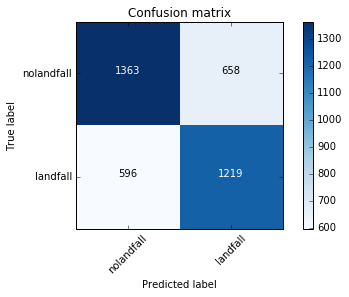

In [58]:
from sklearn import tree


# train the classifier
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

# predict on test yyy
y_test_pred = clf.predict(X_test)

# print metrics
print_metrics(y_test_truth, y_test_pred)

# get confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_truth, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=CLASS_LABELS)

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.666058 |
| average_precision_score | 0.730433 |
| f1_score | 0.646621 |
| recall_score | 0.645730 |
| roc_auc_score | 0.665022 |


**classification_report**:

**confusion_matrix**:

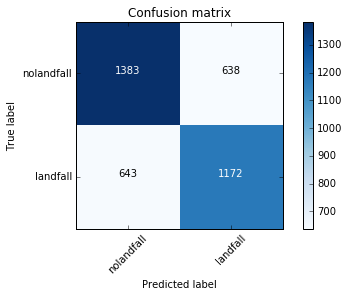

In [59]:
# train the classifier
clf = tree.DecisionTreeClassifier(criterion="entropy")
clf.fit(X_train, y_train)

# predict on test yyy
y_test_pred = clf.predict(X_test)

# print metrics
print_metrics(y_test_truth, y_test_pred)

# get confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_truth, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=CLASS_LABELS)

### Naive Bayes

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.652242 |
| average_precision_score | 0.714765 |
| f1_score | 0.617546 |
| recall_score | 0.593388 |
| roc_auc_score | 0.649242 |


**classification_report**:

**confusion_matrix**:

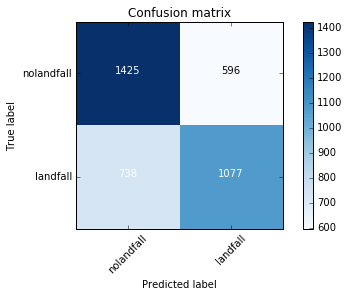

In [60]:
from sklearn import naive_bayes


# train the classifier
clf = naive_bayes.GaussianNB()
clf.fit(X_train, y_train)

# predict on test yyy
y_test_pred = clf.predict(X_test)

# print metrics
print_metrics(y_test_truth, y_test_pred)

# get confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_truth, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=CLASS_LABELS)

### Logistic Regression

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.698905 |
| average_precision_score | 0.758511 |
| f1_score | 0.686907 |
| recall_score | 0.698072 |
| roc_auc_score | 0.698863 |


**classification_report**:

**confusion_matrix**:

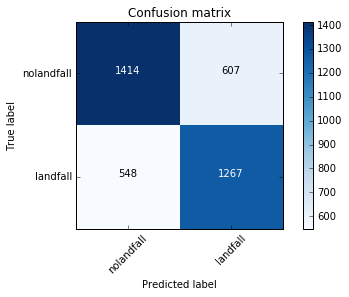

In [61]:
from sklearn import linear_model


# train the classifier
clf = linear_model.LogisticRegression()
clf.fit(X_train, y_train)

# predict on test yyy
y_test_pred = clf.predict(X_test)

# print metrics
print_metrics(y_test_truth, y_test_pred)

# get confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_truth, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=CLASS_LABELS)

### Nearest Neighbor

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.680918 |
| average_precision_score | 0.752020 |
| f1_score | 0.686957 |
| recall_score | 0.739945 |
| roc_auc_score | 0.683926 |


**classification_report**:

**confusion_matrix**:

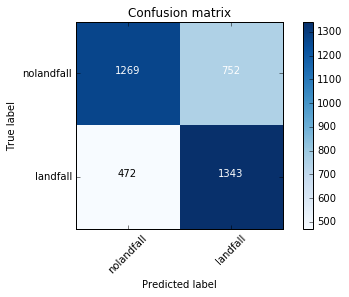

In [62]:
from sklearn import neighbors


# train the classifier
n_neighbors = 5
clf = neighbors.KNeighborsClassifier(n_neighbors)
clf.fit(X_train, y_train)

# predict on test yyy
y_test_pred = clf.predict(X_test)

# print metrics
print_metrics(y_test_truth, y_test_pred)

# get confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_truth, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=CLASS_LABELS)

### Support Vector Machines

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.605579 |
| average_precision_score | 0.663220 |
| f1_score | 0.411513 |
| recall_score | 0.291460 |
| roc_auc_score | 0.589570 |


**classification_report**:

**confusion_matrix**:

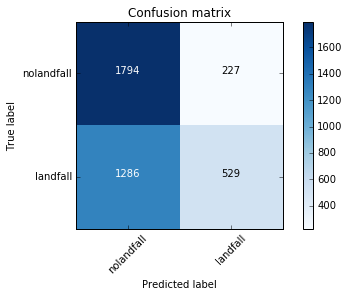

In [72]:
from sklearn import svm


# train the classifier
clf = svm.SVC()
clf.fit(X_train, y_train)

# predict on test yyy
y_test_pred = clf.predict(X_test)

# print metrics
print_metrics(y_test_truth, y_test_pred)

# get confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_truth, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=CLASS_LABELS)

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.701251 |
| average_precision_score | 0.757101 |
| f1_score | 0.675354 |
| recall_score | 0.656749 |
| roc_auc_score | 0.698983 |


**classification_report**:

**confusion_matrix**:

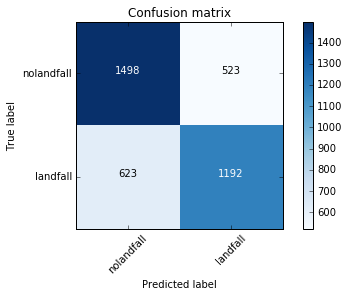

In [64]:
# train the classifier
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

# predict on test yyy
y_test_pred = clf.predict(X_test)

# print metrics
print_metrics(y_test_truth, y_test_pred)

# get confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_truth, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=CLASS_LABELS)

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.692909 |
| average_precision_score | 0.747983 |
| f1_score | 0.649196 |
| recall_score | 0.600551 |
| roc_auc_score | 0.688202 |


**classification_report**:

**confusion_matrix**:

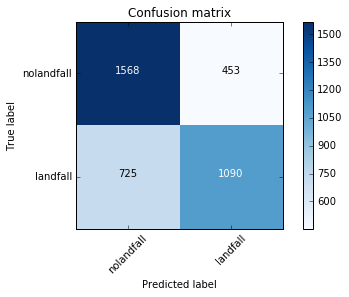

In [67]:
# train the classifier
clf = svm.NuSVC(kernel="linear")
clf.fit(X_train, y_train)

# predict on test yyy
y_test_pred = clf.predict(X_test)

# print metrics
print_metrics(y_test_truth, y_test_pred)

# get confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_truth, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=CLASS_LABELS)

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.690302 |
| average_precision_score | 0.756573 |
| f1_score | 0.690947 |
| recall_score | 0.731680 |
| roc_auc_score | 0.692411 |


**classification_report**:

**confusion_matrix**:

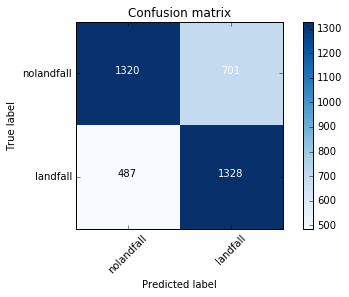

In [68]:
# train the classifier
clf = svm.SVC(kernel='poly', degree=1)
clf.fit(X_train, y_train)

# predict on test yyy
y_test_pred = clf.predict(X_test)

# print metrics
print_metrics(y_test_truth, y_test_pred)

# get confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_truth, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=CLASS_LABELS)

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.694473 |
| average_precision_score | 0.750061 |
| f1_score | 0.659104 |
| recall_score | 0.624242 |
| roc_auc_score | 0.690894 |


**classification_report**:

**confusion_matrix**:

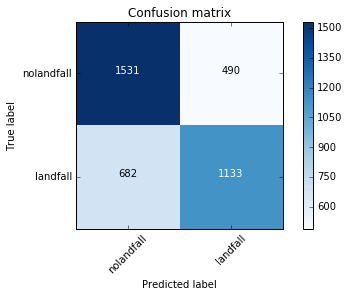

In [69]:
# train the classifier
clf = svm.NuSVC(kernel="poly", degree=1)
clf.fit(X_train, y_train)

# predict on test yyy
y_test_pred = clf.predict(X_test)

# print metrics
print_metrics(y_test_truth, y_test_pred)

# get confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_truth, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=CLASS_LABELS)